# Porównanie 3 metod regresji na podstawie 3 różnych zbiorów danych: Wiek słuchotka (ang. abalone)

W niniejszej pracy wykorzystuję metody:
- K najbliższych sąsiądów (KNN)
- Regresji liniowej
- Lasu losowego

Używam następujących zbiorów danych:
-  [Abalon](https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset)
    - zmienna objaśniana: rings

## Załadowanie potrzebnych bibliotek

In [53]:
import random
import os
from joblib import dump, load

import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import mlflow

%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Stałe

In [27]:
random_state = 0

np.random.seed(random_state)
os.environ["PYTHONHASHSEED"] = str(random_state)
random.seed(random_state)

In [28]:
# if you want to log mlflow and you have the server configured change to True
want_to_log_mlflow = False

log_mlflow = "MLFLOW_TRACKING_URI" in os.environ and want_to_log_mlflow
if log_mlflow: mlflow.set_experiment("Abalone")

In [29]:
sklearn.set_config(transform_output="pandas")

In [54]:
plt.style.use("ggplot")

## Wczytanie danych

In [30]:
abalone = pd.read_csv("../data/abalone.csv")

### Krótka analiza eksploracyjna danych

In [31]:
## uncomment if you want to create an automated EDA report
# ProfileReport(dataset, title=f"Profiling Report for Wine quality dataset").to_file(f"../data/abalone_EDA.html")

## Preprocessing

In [32]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [33]:
abalone.sample(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
668,M,0.550,0.425,0.155,0.9175,0.2775,0.2430,0.3350,13
1580,I,0.500,0.400,0.120,0.6160,0.2610,0.1430,0.1935,8
3784,M,0.620,0.480,0.155,1.2555,0.5270,0.3740,0.3175,11
463,I,0.220,0.165,0.055,0.0545,0.0215,0.0120,0.0200,5
2615,M,0.645,0.500,0.175,1.5105,0.6735,0.3755,0.3775,12


In [34]:
abalone.isna().sum().sort_values(ascending=False)

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [35]:
X = abalone.drop(columns=["Rings"])
y = abalone["Rings"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=random_state)

In [37]:
encoder = make_column_transformer((OneHotEncoder(sparse_output=False), ["Sex"]), 
                                  remainder="passthrough",
                                  n_jobs=-1, 
                                  verbose=True, 
                                  verbose_feature_names_out=False,
                                  )


In [38]:
X_train_preprocessed = encoder.fit_transform(X_train)

# Modelowanie

In [39]:
knn_params = {"n_neighbors": [5, 25, 50],
                "weights": ["uniform", "distance"],
                "leaf_size": [20, 30, 50],
                "p": [1, 2],
                }

random_forest_params = {"n_estimators": [50, 100, 200],
                          # "criterion": ["squared_error", "absolute_error"],
                          "max_depth": [None, 3, 4, 5],
                          "max_features": [None, "sqrt", "log2"],
                          }

Przy wyczerpującym przeszukiwania siatki parametrów w celu znalezienia najlepszej kombinacji parametrów użyjemy walidacji krzyżowej.

[<img src="../img/grid_search_cross_validation.png" alt="drawing" width="400"/>]("../img/grid_search_cross_validation.png") \
źródło: https://scikit-learn.org/stable/modules/cross_validation.html

In [40]:
folds = KFold(n_splits=5, shuffle=True, random_state=random_state)

## Regresja liniowa

In [41]:
linreg = LinearRegression(n_jobs=-1)

In [42]:
linreg.fit(X_train_preprocessed, y_train)

LinearRegression(n_jobs=-1)

In [43]:
linreg.score(X_train_preprocessed, y_train)

0.5365659904594149

### K najbliższych sąsiadów

In [19]:
search_knn = GridSearchCV(estimator=KNeighborsRegressor(n_jobs=-1),
                   param_grid=knn_params,
                   scoring="r2",
                   n_jobs=-1,
                   refit=True,
                   cv=folds,
                   return_train_score=True,
                   verbose=3,
                   )

In [22]:
%%time
search_knn.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 781 ms
Wall time: 17.6 s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 50], 'n_neighbors': [5, 25, 50],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='r2', verbose=3)

In [44]:
## uncomment if you want to save you model
# dump(search_knn, "../models/search_knn_abalone.joblib")
## uncomment if you want load a saved model
search_knn = load("../models/search_knn_abalone.joblib")

In [45]:
pd.DataFrame(search_knn.cv_results_);

### Las losowy

In [26]:
search_random_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=random_state),
                                           param_grid=random_forest_params,
                                           scoring="r2",
                                           n_jobs=-1,
                                           refit=True,
                                           cv=folds,
                                           return_train_score=True,
                                         verbose=3,
                                        )

In [27]:
%%time
search_random_forest.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 5.16 s
Wall time: 1min 36s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='r2', verbose=3)

In [47]:
## uncomment if you want to save you model
# dump(search_random_forest, "../models/search_random_forest_knn_abalone.joblib")
## uncomment if you want load a saved model
search_random_forest = load("../models/search_random_forest_abalone.joblib")

In [48]:
pd.DataFrame(search_random_forest.cv_results_);

## Analiza

Na tym tym posiadam już dostrojone, finalne modele. Teraz zostaną one porównane wg następujących metryk:

- MAE
- MSE
- MAPE
- RMSE
- R2

In [49]:
final_models = [("linear_regression", linreg), ("knn", search_knn.best_estimator_), ("random_forest", search_random_forest.best_estimator_)]

In [50]:
rows = []

for model_name, model in final_models:
    params = search_random_forest.best_estimator_.get_params()
    
    y_pred = model.predict(encoder.transform(X_test))
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {"mae": mae, "mse": mse, "mape": mape, "rmse": rmse, "r2": r2}
    rows.append(metrics)

    if log_mlflow:
        with mlflow.start_run(run_name=model_name) as run:
            mlflow.log_params(params)
        
            mlflow.log_metrics(metrics)
            
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="abalone",
                input_example=X_test,
            )

In [51]:
results = pd.DataFrame(rows, index=[tpl[0] for tpl in final_models])

In [52]:
results.style.format(precision=2, thousands=",")

,mae,mse,mape,rmse,r2
linear_regression,1.55,4.91,0.16,2.22,0.55
knn,1.47,4.67,0.14,2.16,0.57
random_forest,1.52,4.59,0.15,2.14,0.58


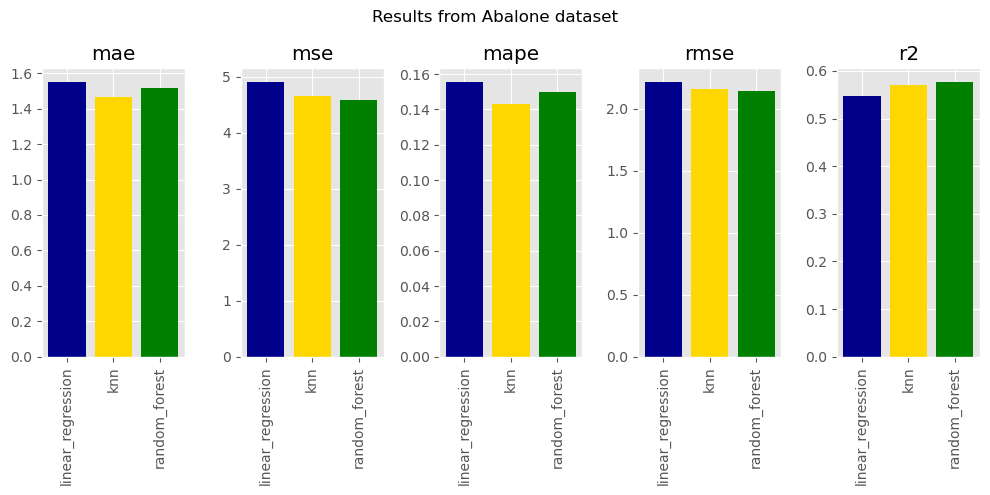

In [55]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
colors = ["darkblue", "gold", "green"]

metrics = results.columns
for i, metric in enumerate(metrics):
    axes[i].bar(results.index, results[metric], color=colors)
    axes[i].set_title(metric)
    axes[i].xaxis.set_ticks([0, 1, 2], results.index, rotation=90)

fig.suptitle("Results from Abalone dataset")
plt.tight_layout()
plt.show()
